In [1]:
import pandas
from tinydb import TinyDB
import numpy
import datetime as dt
import matplotlib.pyplot as mat
import seaborn as sea
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score, mean_squared_log_error, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib
from sklearn.linear_model import LassoCV
import xgboost as xgb

In [2]:
data = pandas.DataFrame(TinyDB('data/db/db.json').table('games').all())
print(data.head())
print(data.shape)

    app_id                               name          category  \
0   536280                     Disintegration      Action Games   
1   982800                        Moon Tycoon  Simulation Games   
2   767960                           Math RTS    Strategy Games   
3  1368670  Beach Volleyball Competition 2020      Sports Games   
4   977800          At Home Alone - Reward 5$   Adventure Games   

                                                tags  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...   
1  [Strategy, Simulation, Indie, Management, Sing...   
2  [Strategy, Indie, Education, RTS, Real-Time, S...   
3  [Sports, Action, Arcade, Character Action Game...   
4  [Strategy, Adventure, Free to Play, RPG, Indie...   

                                     reviews  \
0  {'overall': {'rating': 61, 'count': 120}}   
1           {'overall': 'need_more_reviews'}   
2           {'overall': 'need_more_reviews'}   
3           {'overall': 'need_more_reviews'}   
4           {'overal

In [3]:
# Replacing placeholder value in review data with NaN:
data.loc[(data['reviews'] == {'overall': 'need_more_reviews'}),'reviews'] = numpy.nan
# Splitting review data into overall and recent:
data = pandas.concat([data.drop(['reviews'], axis=1), data['reviews'].apply(pandas.Series)], axis=1)
del data[0]
# Getting rid of recent review data as it is not needed:
del data["recent"]
print(data.head())

    app_id                               name          category  \
0   536280                     Disintegration      Action Games   
1   982800                        Moon Tycoon  Simulation Games   
2   767960                           Math RTS    Strategy Games   
3  1368670  Beach Volleyball Competition 2020      Sports Games   
4   977800          At Home Alone - Reward 5$   Adventure Games   

                                                tags  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...   
1  [Strategy, Simulation, Indie, Management, Sing...   
2  [Strategy, Indie, Education, RTS, Real-Time, S...   
3  [Sports, Action, Arcade, Character Action Game...   
4  [Strategy, Adventure, Free to Play, RPG, Indie...   

                                         playtracker  \
0  {'popularity': 2, 'estimated_players': 159000,...   
1                                                NaN   
2                                                NaN   
3                                   

In [4]:
# Splitting overall review data into two columns:
data = pandas.concat([data.drop(['overall'], axis=1), data['overall'].apply(pandas.Series)], axis=1)
del data[0]
data.rename(columns = {'count':'review_count'}, inplace = True)
print(data.head())

    app_id                               name          category  \
0   536280                     Disintegration      Action Games   
1   982800                        Moon Tycoon  Simulation Games   
2   767960                           Math RTS    Strategy Games   
3  1368670  Beach Volleyball Competition 2020      Sports Games   
4   977800          At Home Alone - Reward 5$   Adventure Games   

                                                tags  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...   
1  [Strategy, Simulation, Indie, Management, Sing...   
2  [Strategy, Indie, Education, RTS, Real-Time, S...   
3  [Sports, Action, Arcade, Character Action Game...   
4  [Strategy, Adventure, Free to Play, RPG, Indie...   

                                         playtracker  \
0  {'popularity': 2, 'estimated_players': 159000,...   
1                                                NaN   
2                                                NaN   
3                                   

In [5]:
# Splitting playtracker into multiple columns:
data = pandas.concat([data.drop(['playtracker'], axis=1), data['playtracker'].apply(pandas.Series)], axis=1)
del data[0]
print(data.head())

    app_id                               name          category  \
0   536280                     Disintegration      Action Games   
1   982800                        Moon Tycoon  Simulation Games   
2   767960                           Math RTS    Strategy Games   
3  1368670  Beach Volleyball Competition 2020      Sports Games   
4   977800          At Home Alone - Reward 5$   Adventure Games   

                                                tags  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...   
1  [Strategy, Simulation, Indie, Management, Sing...   
2  [Strategy, Indie, Education, RTS, Real-Time, S...   
3  [Sports, Action, Arcade, Character Action Game...   
4  [Strategy, Adventure, Free to Play, RPG, Indie...   

                                            steamspy  review_count  rating  \
0  {'price': 39.99, 'discount': 0.0, 'release_dat...         120.0    61.0   
1  {'price': 4.99, 'discount': 50.0, 'release_dat...           NaN     NaN   
2  {'price': 4.99, 'discou

In [6]:
# Splitting categories into multiple columns:
cat = pandas.DataFrame(data["category"])
cat = pandas.get_dummies(cat)
# Merging back together:
del data["category"]
data = data.merge(cat, left_index=True, right_index=True)
print(data.head())

    app_id                               name  \
0   536280                     Disintegration   
1   982800                        Moon Tycoon   
2   767960                           Math RTS   
3  1368670  Beach Volleyball Competition 2020   
4   977800          At Home Alone - Reward 5$   

                                                tags  \
0  [FPS, PvE, Vehicular Combat, RTS, Shooter, Str...   
1  [Strategy, Simulation, Indie, Management, Sing...   
2  [Strategy, Indie, Education, RTS, Real-Time, S...   
3  [Sports, Action, Arcade, Character Action Game...   
4  [Strategy, Adventure, Free to Play, RPG, Indie...   

                                            steamspy  review_count  rating  \
0  {'price': 39.99, 'discount': 0.0, 'release_dat...         120.0    61.0   
1  {'price': 4.99, 'discount': 50.0, 'release_dat...           NaN     NaN   
2  {'price': 4.99, 'discount': 0.0, 'release_date...           NaN     NaN   
3  {'price': 5.99, 'discount': 50.0, 'release_dat...    

In [7]:
# Splitting the dataset into two to make operations for tags easier:
game_info = data.copy()
del game_info['tags']
tags = pandas.DataFrame(data['tags'])
# Creating a column for each tag:
tags = pandas.concat([tags.drop(['tags'], axis=1), tags['tags'].apply(pandas.Series)], axis=1)
tags = pandas.get_dummies(tags)
tags.rename(columns=lambda x: x.split("_")[1], inplace=True)
tags.rename(columns=lambda x: 'tag_' + x, inplace=True)
tags = tags.groupby(level=0, axis=1).sum()
print(game_info.head())
print(tags.head())

    app_id                               name  \
0   536280                     Disintegration   
1   982800                        Moon Tycoon   
2   767960                           Math RTS   
3  1368670  Beach Volleyball Competition 2020   
4   977800          At Home Alone - Reward 5$   

                                            steamspy  review_count  rating  \
0  {'price': 39.99, 'discount': 0.0, 'release_dat...         120.0    61.0   
1  {'price': 4.99, 'discount': 50.0, 'release_dat...           NaN     NaN   
2  {'price': 4.99, 'discount': 0.0, 'release_date...           NaN     NaN   
3  {'price': 5.99, 'discount': 50.0, 'release_dat...           NaN     NaN   
4  {'price': 4.99, 'discount': 0.0, 'release_date...           NaN     NaN   

   average_playtime  estimated_active_players  estimated_players  popularity  \
0               0.6                   25000.0           159000.0         2.0   
1               NaN                       NaN                NaN         NaN

In [8]:
# Merging the tables back together:
games = game_info.merge(tags, left_index=True, right_index=True)
print(games.head())
print(games.shape)

    app_id                               name  \
0   536280                     Disintegration   
1   982800                        Moon Tycoon   
2   767960                           Math RTS   
3  1368670  Beach Volleyball Competition 2020   
4   977800          At Home Alone - Reward 5$   

                                            steamspy  review_count  rating  \
0  {'price': 39.99, 'discount': 0.0, 'release_dat...         120.0    61.0   
1  {'price': 4.99, 'discount': 50.0, 'release_dat...           NaN     NaN   
2  {'price': 4.99, 'discount': 0.0, 'release_date...           NaN     NaN   
3  {'price': 5.99, 'discount': 50.0, 'release_dat...           NaN     NaN   
4  {'price': 4.99, 'discount': 0.0, 'release_date...           NaN     NaN   

   average_playtime  estimated_active_players  estimated_players  popularity  \
0               0.6                   25000.0           159000.0         2.0   
1               NaN                       NaN                NaN         NaN

In [9]:
# Checking if the tags seem right for tag "Strategy":
print(games["tag_Strategy"].head())
# They seem to be right.

0    1
1    1
2    1
3    0
4    1
Name: tag_Strategy, dtype: uint8


In [10]:
# Splitting steamspy data into multiple columns:
games = pandas.concat([games.drop(['steamspy'], axis=1), games['steamspy'].apply(pandas.Series)], axis=1)
print(games.head())

    app_id                               name  review_count  rating  \
0   536280                     Disintegration         120.0    61.0   
1   982800                        Moon Tycoon           NaN     NaN   
2   767960                           Math RTS           NaN     NaN   
3  1368670  Beach Volleyball Competition 2020           NaN     NaN   
4   977800          At Home Alone - Reward 5$           NaN     NaN   

   average_playtime  estimated_active_players  estimated_players  popularity  \
0               0.6                   25000.0           159000.0         2.0   
1               NaN                       NaN                NaN         NaN   
2               NaN                       NaN                NaN         NaN   
3               NaN                       NaN                NaN         NaN   
4               NaN                       NaN                NaN         NaN   

   category_- Arcane Raise -  category_Action  ...  tag_Western  \
0                        

In [11]:
games = pandas.concat([games.drop(['release_date'], axis=1), games['release_date'].apply(pandas.Series)], axis=1)
games['release_date'] = pandas.to_datetime(games[['year', 'month', 'day']])
games['years_since_release'] = ((pandas.to_datetime("2020-09-14") - games['release_date']).dt.days) / 365
# Checking whether there are missing values (especially for date values):
print(games.isnull().sum())
# For more than half of the games review data is missing. For playtracker data even more.
# Since the number of missing values are the same for day, month and year, there's no need to impute one of them:
del games[0]
del games['year']
del games['month']
del games['day']
print(games.head())

app_id                     0
name                       0
review_count           43741
rating                 43741
average_playtime       56230
                       ...  
day                     6139
month                   6139
year                    6139
release_date            6139
years_since_release     6139
Length: 553, dtype: int64
    app_id                               name  review_count  rating  \
0   536280                     Disintegration         120.0    61.0   
1   982800                        Moon Tycoon           NaN     NaN   
2   767960                           Math RTS           NaN     NaN   
3  1368670  Beach Volleyball Competition 2020           NaN     NaN   
4   977800          At Home Alone - Reward 5$           NaN     NaN   

   average_playtime  estimated_active_players  estimated_players  popularity  \
0               0.6                   25000.0           159000.0         2.0   
1               NaN                       NaN                NaN    

In [12]:
# Investigating if nas in playtracker are in the same places as in review data:
games['both_na'] = numpy.where(((games['estimated_players'].isnull()) & (games['rating'].isnull())), 1, 0)
print(sum(games['both_na']))

39154


In [13]:
# It can be concluded that those are games that do not have any players:
games['estimated_players'] = games.apply(lambda x : x['estimated_players'] if x['both_na'] == 0 else 0, axis=1)
games['estimated_active_players'] = games.apply(lambda x : x['estimated_active_players'] if x['both_na'] == 0 else 0, axis=1)
games['average_playtime'] = games.apply(lambda x : x['average_playtime'] if x['both_na'] == 0 else 0, axis=1)
games['popularity'] = games.apply(lambda x : x['popularity'] if x['both_na'] == 0 else 0.0, axis=1)
games['rating'] = games.apply(lambda x : x['rating'] if x['both_na'] == 0 else 0.0, axis=1)
games['review_count'] = games.apply(lambda x : x['review_count'] if x['both_na'] == 0 else 0.0, axis=1)
del games['both_na']
print(games.isnull().sum())
# The quantity of nas was reduced by a considerable amount.

app_id                     0
name                       0
review_count            4587
rating                  4587
average_playtime       17076
                       ...  
tag_eSports                0
price                   9576
discount                9576
release_date            6139
years_since_release     6139
Length: 549, dtype: int64


In [14]:
# Dropping the rows where 'estimated_players' is na as it is the variable we want to predict.
games = games[games['estimated_players'].notna()]
# Dropping the rows where 'rating' is na as well as those are online about 4500 and would
# hinder our predictions otherwise:
games = games[games['rating'].notna()]
print(games.isnull().sum())
# There are still quite a few missing values in the former steamspy data. Where the release that is given, the
# price and discount will simply be imputed with the mean values. The rows where the release date is missing will be
# dropped as the release date is an important indicator for the number of players.
games = games[games['release_date'].notna()]
games['price'].fillna(games['price'].mean(), inplace=True)
games['discount'].fillna(games['discount'].mean(), inplace=True)
print(games.isnull().sum())

app_id                    0
name                      0
review_count              0
rating                    0
average_playtime          0
                       ... 
tag_eSports               0
price                  8317
discount               8317
release_date           5707
years_since_release    5707
Length: 549, dtype: int64
app_id                 0
name                   0
review_count           0
rating                 0
average_playtime       0
                      ..
tag_eSports            0
price                  0
discount               0
release_date           0
years_since_release    0
Length: 549, dtype: int64


In [15]:
# Get summary for a number of columns (most of categories and tags left out):
print(games.describe())
# It's visible that for the playtracker and review data more than 50% have the value 0. This
# is a consequence of the imputation. But as mentioned, it is assumed that the data was missing
# because these were games that no one plays.
# It's also visible that most games have no discount (75% quantil still 0) and most of them are
# relatively new.

       review_count        rating  average_playtime  estimated_active_players  \
count  4.885100e+04  48851.000000      48851.000000              4.885100e+04   
mean   4.550175e+02     23.209310          1.180357              9.439766e+03   
std    8.930217e+03     35.928915          5.649756              8.105955e+04   
min    0.000000e+00      0.000000          0.000000              0.000000e+00   
25%    0.000000e+00      0.000000          0.000000              0.000000e+00   
50%    0.000000e+00      0.000000          0.000000              0.000000e+00   
75%    2.300000e+01     60.000000          0.400000              1.000000e+03   
max    1.296235e+06    100.000000        284.600000              8.000000e+06   

       estimated_players    popularity  category_- Arcane Raise -  \
count       4.885100e+04  48851.000000               48851.000000   
mean        1.371055e+05      1.077460                   0.000020   
std         5.275239e+05      4.667733                   0.0045

In [16]:
# Checking for negative values of years_since_release, since the min-value is negative:
print(games.loc[games['years_since_release'] < 0])
# It seems there are 1048 games that weren't released yet. They will get dropped as they can't give
# an indication about the number of players:
games = games[games['years_since_release'] >= 0]
print(games.describe())

        app_id                                            name  review_count  \
235    1291037         Simplode Suite - Basic Power Management           0.0   
278    1137390                                   Kyber Knights           0.0   
311    1366620                            Nyanroo The Supercat           0.0   
323    1339340                             The Unbeatable Path           0.0   
420     970830  The Dungeon Of Naheulbeuk: The Amulet Of Chaos           0.0   
...        ...                                             ...           ...   
75596  1389850                                Digital Janitors           0.0   
75686   720560                        Vigil: The Longest Night           0.0   
75862   583750                                     Skyclimbers           0.0   
76046  1389440                                 Call of Knights           0.0   
76070   912900                                  Bunker Defense           0.0   

       rating  average_playtime  estima

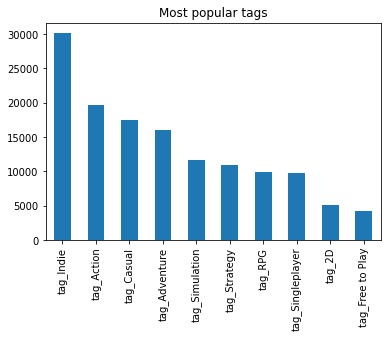

                      0
tag_Indie         30146
tag_Action        19611
tag_Casual        17501
tag_Adventure     16056
tag_Simulation    11617
...                 ...
tag_Benchmark         4
tag_Feature Film      4
tag_Reboot            3
tag_Action RTS        2
tag_Breathtaking      1

[422 rows x 1 columns]


In [17]:
# Counting the occurences of tags:
tag_filter = [col for col in games if col.startswith('tag_')]
tag_cols = games[tag_filter]
tag_count = tag_cols.sum()
tag_c = pandas.DataFrame(tag_count)
tag_c = tag_c.sort_values(by=0, ascending=False)
topten = tag_c.iloc[:10]
topten[0].plot(kind='bar')
mat.title(f'Most popular tags')
mat.show()

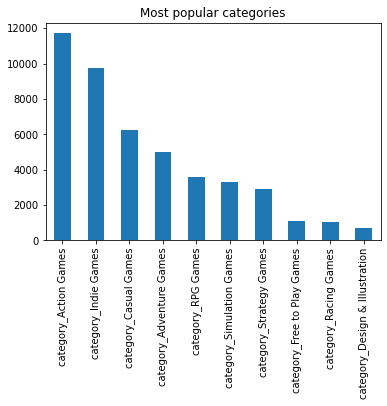

In [28]:
# Barplot of the 10 most common categories:
cat_filter = [col for col in games if col.startswith('category_')]
cat_cols = games[cat_filter]
cat_count = cat_cols.sum()
cat_c = pandas.DataFrame(cat_count)
cat_c = cat_c.sort_values(by=0, ascending=False)
top = cat_c.iloc[:10]
top[0].plot(kind='bar')
mat.title('Most popular categories')
mat.show()
# Dropping categories that include less than two games:
small_cat = cat_c[cat_c[0] < 2].index
games = games.drop(games[small_cat], axis=1)

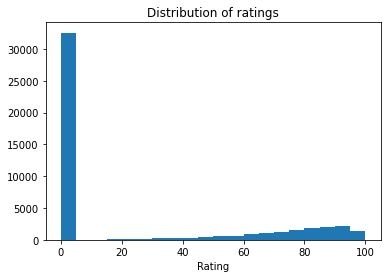

In [29]:
# Histogram ratings:
mat.hist(x=games['rating'], bins=20)
mat.title('Distribution of ratings')
mat.xlabel('Rating')
mat.show()
# Though it seems, that there are a lot of games that have a very low ranking, this should be a consequence
# of the imputation.

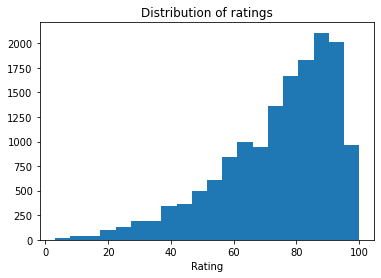

In [30]:
# To get a better impression of the distribution, only ratings > 0 will be viewed next:
rated_games = games[games['rating']>0]
mat.hist(x=rated_games['rating'], bins=20)
mat.title('Distribution of ratings')
mat.xlabel('Rating')
mat.show()
# Most games seem to have a fairly good to very good rating.

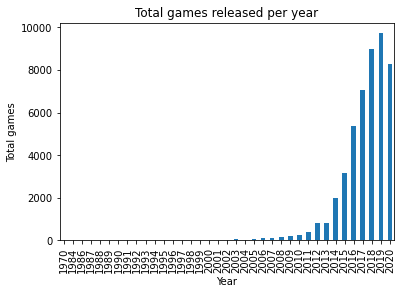

In [31]:
# Barplot number of game releases per year:
games_per_year = games.groupby(games['release_date'].dt.year.rename('release_year')).agg('count')['name']
games_per_year.plot(y=games_per_year, x=games_per_year.index, kind='bar')
mat.title('Total games released per year')
mat.xlabel('Year')
mat.ylabel('Total games')
mat.show()
# There are very few games from before 2005 in the dataset. Most of the games a very new as the later the higher the
# bar (apart from 2020 in which we are only three quarters in).

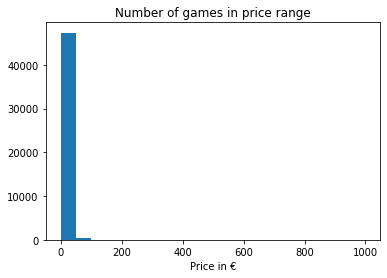

In [32]:
# Histogram number of games in a specific price range:
mat.hist(x=games['price'], bins=20)
mat.title('Number of games in price range')
mat.xlabel('Price in €')
mat.show()
# Most games cost less than a hundred.

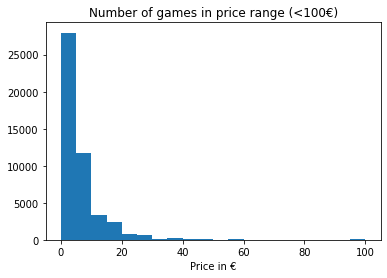

6478


In [33]:
# To be able to get a better impression of the distribution of the price, games for more than 100€ get cut off:
cheap_games = games[games['price']<100]
mat.hist(x=cheap_games['price'], bins=20)
mat.title('Number of games in price range (<100€)')
mat.xlabel('Price in €')
mat.show()
# Most games seem to cost less than 5€.
print(len(games[games['price']==0]))
# Of the almost 30,000 games that cost less than 5€, about 6,500 are actually free.

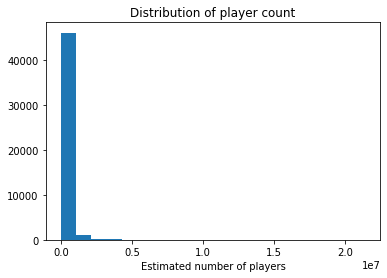

In [34]:
# Histogram number of players:
mat.hist(x=games['estimated_players'], bins=20)
mat.title('Distribution of player count')
mat.xlabel('Estimated number of players')
mat.show()
# There are very few games that have more than 5,000,000 players and most games seem to have less than
# 1,000,000 players.

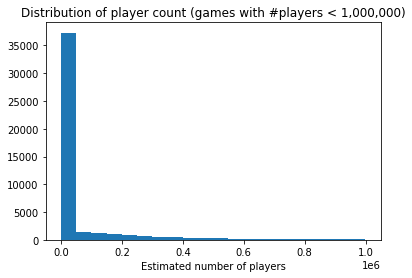

In [35]:
# Again, to get a better overview over the games, games with more than 1,000,000 players get cut off:
low_pc_games = games[games['estimated_players']<1000000]
mat.hist(x=low_pc_games['estimated_players'], bins=20)
mat.title('Distribution of player count (games with #players < 1,000,000)')
mat.xlabel('Estimated number of players')
mat.show()
# Still most games have a relatively low player count or no players at all.

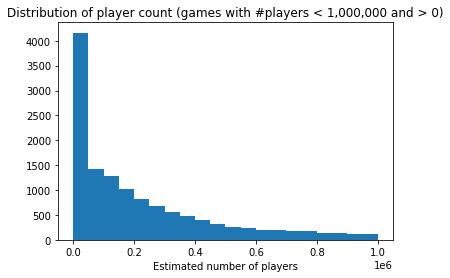

In [36]:
# To see the distribution of player counts of games that are actually played, games with a player count of 0
# get cut off as well:
played_games = low_pc_games[low_pc_games['estimated_players']>0]
mat.hist(x=played_games['estimated_players'], bins=20)
mat.title('Distribution of player count (games with #players < 1,000,000 and > 0)')
mat.xlabel('Estimated number of players')
mat.show()
# As suspected before, most games really have very few players.

Text(0, 0.5, 'Number of players')

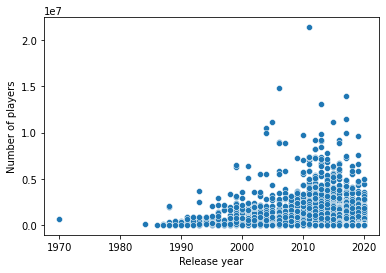

In [37]:
# Scatterplot Release year/number of players:
sea.scatterplot(data=games, x=games['release_date'].dt.year, y='estimated_players')
mat.xlabel('Release year')
mat.ylabel('Number of players')
# The most popular games were released after 2000. Though as visible above, there were also a lot more games released
# after 2005.

Text(0, 0.5, 'Number of players')

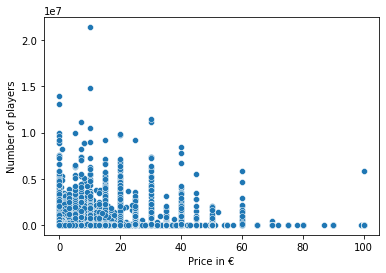

In [38]:
# Scatterplot price(<100€)/number of players (using dataset cheap_game from before):
sea.scatterplot(data=cheap_games, x='price', y='estimated_players')
mat.xlabel('Price in €')
mat.ylabel('Number of players')
# Games seem to get less popular with a lower price apart from an outlier at 100€. Though, again it has
# to be noted that there are a lot more games in the lower price range.

Text(0, 0.5, 'Number of players')

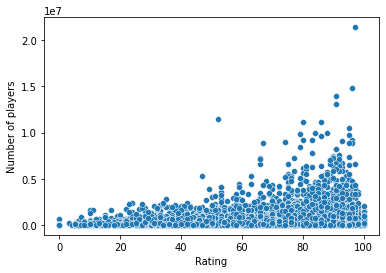

In [39]:
# Scatterplot rating/number of players:
sea.scatterplot(data=games, x='rating', y='estimated_players')
mat.xlabel('Rating')
mat.ylabel('Number of players')
# As expected, games that have a high ranking also more players.

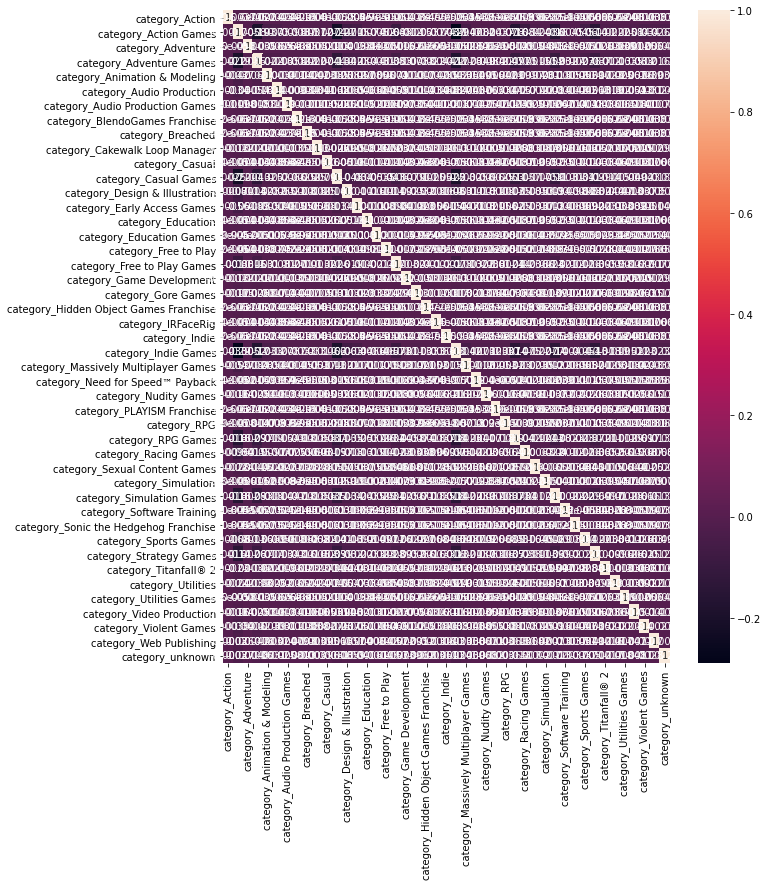

In [49]:
# Correlation matrix for categories:
cat_corr_matrix = cat_cols.corr()
sea.heatmap(cat_corr_matrix, annot=True)
mat.show()
# This correlation matrix is of course not very readable, but as the color indicates the correlation
# and the whole graph is a lighter or darker shade of violet, it seems that there are no/very few correlations
# that 0.3/-0.3.
# There'll be no correlation matrix for tags as there are to many of them.

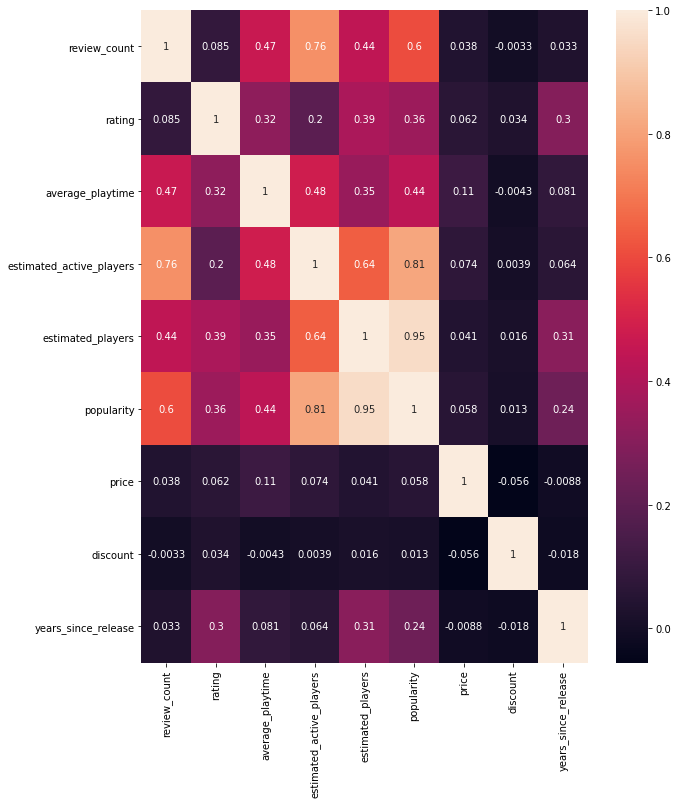

In [54]:
# Correlation matrix for other columns:
other_cols = games[['review_count', 'rating', 'average_playtime', 'estimated_active_players', 'estimated_players',
                  'popularity', 'price', 'discount', 'years_since_release']]
other_corr_matrix = other_cols.corr()
sea.heatmap(other_corr_matrix, annot=True)
mat.show()
# Of course, the columns average_playtime, estimated_[active]_players and popularity have a medium to high
# correlation to each other and to review_count and rating. As this kind of things go hand in hand with each
# other, it is to be expected.

In [40]:
# Splitting the data into train and test:
x = games.copy()
del x['app_id']
del x['name']
del x['estimated_players']
del x['estimated_active_players']
del x['release_date']
del x['popularity']
del x['review_count']
del x['rating']
del x['average_playtime']
y = pandas.DataFrame(numpy.log(games['estimated_players']))
y[numpy.isneginf(y)] = 0
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state = 206, shuffle=True)

C:\Users\Annalisa\AppData\Roaming\Python\Python38\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
# Training a linear regression model:
x_train_c = sm.add_constant(x_train)
x_test_c = sm.add_constant(x_test)
model = sm.OLS(y_train, x_train_c).fit()
# Avoiding negative predictions:
pred = numpy.maximum(0., model.predict(x_test_c))
print("RMSE:", numpy.sqrt(mean_squared_error(y_test, pred)))
print("RMSLE:", numpy.sqrt(mean_squared_log_error(y_test, pred)))
print("MAE:", median_absolute_error(y_test, pred))
print(y['estimated_players'].mean())
model_summary = model.summary()
print(model_summary)

RMSE: 4.026288540449084
RMSLE: 1.0234912384792838
MAE: 2.239355999458625
3.627569529942997
                            OLS Regression Results                            
Dep. Variable:      estimated_players   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     73.27
Date:                Tue, 06 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:34:08   Log-Likelihood:            -1.0745e+05
No. Observations:               38242   AIC:                         2.158e+05
Df Residuals:                   37771   BIC:                         2.199e+05
Df Model:                         470                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
------------

In [44]:
# Training a Decision Tree Regressor:
model2 = DecisionTreeRegressor(random_state=42)
result2 = model2.fit(x_train, y_train)
pred2 = result2.predict(x_test)
print("Accuracy:", result2.score(x_test, y_test))
print("RMSE:", numpy.sqrt(mean_squared_error(y_test, pred2)))
print("RMSLE:", numpy.sqrt(mean_squared_log_error(y_test, pred2)))
print("MAE:", median_absolute_error(y_test, pred2))
print(y['estimated_players'].mean())
# Though the accuracy and RMSE got worse for the decision tree regression, the RMSLE got better. This
# indicates that the decision tree model is better in predicting the majority of the data, but worse for
# outliers as RMSLE is less sensitive for outliers.

Accuracy: 0.4558696698161655
RMSE: 4.050089586938215
RMSLE: 0.8886588323946012
MAE: 0.0
3.627569529942997


In [45]:
# Training a Random Forest Regressor:
model3 = RandomForestRegressor(max_features=None, min_samples_split=4, n_estimators=130, random_state=42)
result3 = model3.fit(x_train, y_train)
pred3 = result3.predict(x_test)
print("Accuracy:", result3.score(x_test, y_test))
print("RMSE:", numpy.sqrt(mean_squared_error(y_test, pred3)))
print("RMSLE:", numpy.sqrt(mean_squared_log_error(y_test, pred3)))
print("MAE:", median_absolute_error(y_test, pred3))
print(y['estimated_players'].mean())
# This seems to be the best model yet as all measures except MAE improved.

<ipython-input-45-fc5b1b8f7000>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result3 = model3.fit(x_train, y_train)


Accuracy: 0.698877960343215
RMSE: 3.012898036006796
RMSLE: 0.7317441598915833
MAE: 0.3352842869398896
3.627569529942997


In [46]:
# Training a multi layer Perceptron Regressor:
multPerceptronReg = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_train)
# Avoiding negative predictions:
predperctron = numpy.maximum(0., multPerceptronReg.predict(x_test))
print("Score Multilayer Perceptron Regressor:", multPerceptronReg.score(x_test, y_test))
print("RMSE:", numpy.sqrt(mean_squared_error(y_test, predperctron)))
print("RMSLE:", numpy.sqrt(mean_squared_log_error(y_test, predperctron)))
print("MAE:", median_absolute_error(y_test, predperctron))
print(y['estimated_players'].mean())
# The perceptron performed worse than random forest in all aspects.

C:\Users\Annalisa\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Score Multilayer Perceptron Regressor: 0.534207519355339
RMSE: 3.5537935149015816
RMSLE: 0.8089952291163406
MAE: 0.6994519705200084
3.627569529942997


C:\Users\Annalisa\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best alpha using built-in LassoCV: 0.006050
Best score using built-in LassoCV: 0.435807
RMSE: 4.117777635095037
RMSLE: 1.0548808814658008
MAE: 2.4405472287113716
3.627569529942997
LassoCV chose 130 variables and dropped the other 340 to zero a like.


Text(0.5, 1.0, 'Features (variables) and its importance choosen by LassoCV')

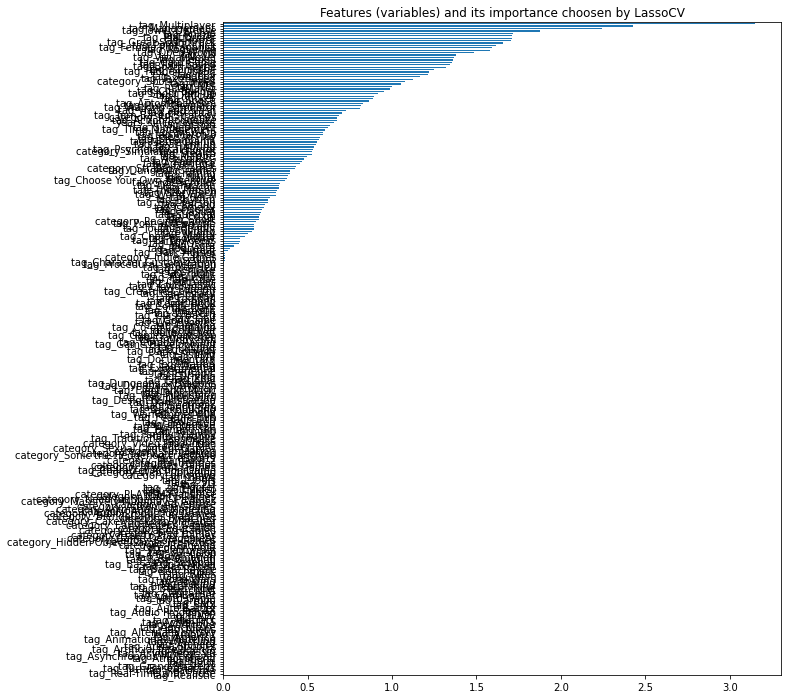

In [59]:
#Make Predictions with a Lasso
lassoModel = LassoCV()
lassoModel.fit(x_train, y_train)
print("Best alpha using built-in LassoCV: %f" % lassoModel.alpha_)
print("Best score using built-in LassoCV: %f" % lassoModel.score(x_test, y_test))
coef = pandas.Series(lassoModel.coef_, index = x_train.columns)
# Avoiding negative predictions:
label_y_predict_lasso = numpy.maximum(0., lassoModel.predict(x_test))
print("RMSE:", numpy.sqrt(mean_squared_error(y_test, label_y_predict_lasso)))
print("RMSLE:", numpy.sqrt(mean_squared_log_error(y_test, label_y_predict_lasso)))
print("MAE:", median_absolute_error(y_test, label_y_predict_lasso))
print(y["estimated_players"].mean())
print("LassoCV chose", str(sum(coef != 0)), "variables and dropped the other",  str(sum(coef == 0)), "to zero a like.")
coeffs_sorted = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (10.0, 12.0)
coeffs_sorted[200:].plot(kind = "barh")
mat.title("Features (variables) and its importance choosen by LassoCV")
# Lasso also performed worse than random forest in all aspects.

In [48]:
#Make Predictions using xgboost:
xgbreg = xgb.XGBRegressor(colsample_bytree=0.7, learning_rate=0.5, max_depth=7, n_estimators=110, subsample=0.8, reg_alpha=0.6, random_state=42) 
xgb_result = xgbreg.fit(x_train, y_train)
xgb_pred = numpy.maximum(0., xgb_result.predict(x_test))
print("Accuracy:", xgb_result.score(x_test, y_test))
print("RMSE:", numpy.sqrt(mean_squared_error(y_test, xgb_pred)))
print("RMSLE:", numpy.sqrt(mean_squared_log_error(y_test, xgb_pred)))
print("MAE:", median_absolute_error(y_test, xgb_pred))
print(y['estimated_players'].mean())
# xgboost performs worse than Random Forest for all measures.

Accuracy: 0.654637426758004
RMSE: 3.2028242604751647
RMSLE: 0.797600538913358
MAE: 0.896837592124939
3.627569529942997


In [ ]:
#saving the trained tree model
import pickle
import joblib
# Save the trained model as a pickle
modelFileName = "trained_model.pkl"
joblib.dump(result3, modelFileName)

####### TO IMPORT AND USE IT USE THIS #####
## Load from file
#joblib_model = joblib.load(modelFileName)
## Calculate the accuracy and predictions
#Ypredict = joblib_model.predict(x_input_to_predict)